Runs OK but needs debugging as to why losses are so high and box predictions so poor

predictions made on 226x226 scaled images. Would need to upscale to original size for submission

In [88]:
# coding: utf-8

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

from fastai.conv_learner import *
from fastai.dataset import *

In [89]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

In [90]:
#SHORT_CYCLE_LEN=3
#CYCLE_LEN=5
SHORT_CYCLE_LEN=1
CYCLE_LEN=1

RESIZE_DIM = 224

PATH = Path('data')
RESIZED_PATH = PATH/'resized_224'
JPEGS = 'train'
IMG_PATH = RESIZED_PATH/JPEGS

IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name','id','image_id','category_id','bbox'

In [91]:
def save_file(text, name):
    with open("temp/" + name + ".txt", "w") as text_file:
        text_file.write(text)

In [92]:
cats = {1: 'Type_0', 2: 'Type_1', 3: 'Type_2', 4: 'Type_3', 5: 'Type_4', 6:'Type_5'}
inverted_cats = dict(zip(cats.values(),cats.keys()))
#print(f'inverted_cats: {inverted_cats}')
#print(f'cats: {cats}')

In [93]:
train = pd.read_csv(RESIZED_PATH/f'train_with_labels_scaled_{RESIZE_DIM}.csv')
print(f'problem with: {train.ix[44]}')
print(f'problem with: {train.ix[195]}')
#train = train[300:]
train = train.drop(train.index[44])
train = train.drop(train.index[194])
#limit to first 10
#train=train[0:4]
# check the new columns
#train.loc[0:10, 'scaled_5_X_1':'scaled_11_X_3']

problem with: OutputID         Image228_1TPP_4R_MT.JPG
row_1_X_1                            158
row_1_Y_1                            786
row_1_X_2                           1476
row_1_Y_2                            861
row_1_X_3                           1489
row_1_Y_3                            762
row_1_X_4                            161
row_1_Y_4                            683
row_2_X_1                            163
row_2_Y_1                            681
row_2_X_2                           1487
row_2_Y_2                            758
row_2_X_3                           1494
row_2_Y_3                            661
row_2_X_4                            167
row_2_Y_4                            578
row_3_X_1                            168
row_3_Y_1                            572
row_3_X_2                           1493
row_3_Y_2                            654
row_3_X_3                           1499
row_3_Y_3                            557
row_3_X_4                            174
ro

/home/walle/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/walle/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
trn_ids = list(train.id)
trn_values = list(train.OutputID)
trn_fns = dict(zip(trn_ids, trn_values))

In [95]:
#print(f'trn_fns: {trn_fns}')

# note height and width are post padding
def get_trn_anno(coord_prefix='scaled'):
    trn_coords = collections.defaultdict(lambda: [])
    trn_anno = collections.defaultdict(lambda: [])
    for index, row in train.iterrows():
        #print(row)
        if coord_prefix == 'scaled':
            scalar = row['scalar']
            height = RESIZE_DIM
        else:
            height = int(row['height'])
        for n in range(1, 12):
            if row[f'row_{n}_Y_2'] != 0 and row[f'row_{n}_X_2'] != 0:
                y1_from_top = height - row[f'{coord_prefix}_{n}_Y_1']
                y2_from_top = height - row[f'{coord_prefix}_{n}_Y_2']
                y3_from_top = height - row[f'{coord_prefix}_{n}_Y_3']
                y4_from_top = height - row[f'{coord_prefix}_{n}_Y_4']
                # note we use 1,1 and 3,3 for the extremities
                bb = np.array(
                    [y1_from_top, row[f'{coord_prefix}_{n}_X_1'], y3_from_top, row[f'{coord_prefix}_{n}_X_3']])
                coords = np.array(
                    [y1_from_top, row[f'{coord_prefix}_{n}_X_1'], y2_from_top, row[f'{coord_prefix}_{n}_X_2'],
                     y3_from_top, row[f'{coord_prefix}_{n}_X_3'], y4_from_top, row[f'{coord_prefix}_{n}_X_4']])
                trn_coords[row['id']].append((coords, inverted_cats[row['Main_type']]))
                trn_anno[row['id']].append((bb, inverted_cats[row['Main_type']]))
    return trn_coords, trn_anno

trn_coords, trn_anno = get_trn_anno()
#print(f'trn_anno: {trn_anno}')

In [96]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

def get_lrg(b):
    #largest box in image
    if not b:
        raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

def get_sml(b):
    #smallest box in image
    if not b:
        raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=False)
    return b[0]

In [97]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}
trn_sml_anno = {a: get_sml(b) for a,b in trn_anno.items()}
#for pic in trn_sml_anno:
#    smallest =
#print(f'trn_sml_anno: {trn_sml_anno}')
areas={}
for k,v in trn_sml_anno.items():
    b = v[0]
    area = (b[2]-b[0])*(b[3]-b[1])
    areas[k]=abs(area)
#print(f'min area: {min(areas.values())}')

<function matplotlib.pyplot.close(*args)>

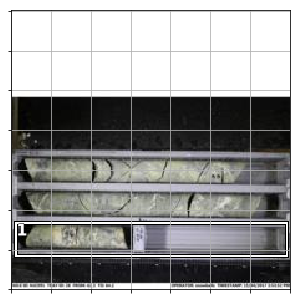

In [98]:
#check an image

b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], c, sz=16)
plt.savefig(f'figs/g2c_largest_box_23.jpg')
plt.close


In [99]:
# ## Box per cell
# 
print('>>Box per cell')

start_bpc = timer()

#set up csv files
CLAS_CSV = RESIZED_PATH/'tmp/clas.csv'
MBB_CSV = RESIZED_PATH/'tmp/mbb.csv'


>>Box per cell


In [100]:
f_model = resnet34
sz = 224
bs = 64

In [101]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k, v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])

In [102]:
#print(f'id2cat: {id2cat}')

#print(f'mcs: {mcs}')
#print(f'trn_fns: {trn_fns}')

In [103]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)

#print(f'val_idxs: {val_idxs}')

mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)
print(f'MBB_CSV df: {df.head()}')

MBB_CSV df:                          fn                                               bbox
0  Image376_1TPP_4R_PL2.jpg  65 6 80 217 82 6 96 217 99 6 113 217 116 6 130...
1   Image208_1TPP_3R_MT.jpg       101 14 121 214 124 14 138 215 143 15 160 216
2   Image212_1TPP_3R_MT.jpg       102 14 121 215 124 15 139 215 144 15 160 216
3   Image202_1TPP_3R_MT.jpg       102 14 119 214 123 14 138 215 143 15 160 216
4   Image242_2TPP_4R_MT.JPG  72 9 87 216 88 9 103 217 105 9 119 217 121 8 1...


In [104]:
#augmentations
aug_tfms = [RandomRotate(10, tfm_y = TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD)]

tfms = tfms_from_model(f_model, sz, aug_tfms=aug_tfms, tfm_y=TfmType.COORD, crop_type=CropType.NO)
#regression for coords
md = ImageClassifierData.from_csv(RESIZED_PATH, JPEGS, MBB_CSV, bs, tfms=tfms, continuous=True)

setting shuffle for trn_ds to false


In [105]:
'''
save_file(str(trn_anno), 'g2c_trn_anno')
save_file(str(trn_fns), 'g2c_trn_fns')
save_file(str(trn_mcs), 'g2c_trn_mcs')
save_file(str(val_mcs), 'g2c_val_mcs')

assert True==False
'''

"\nsave_file(str(trn_anno), 'g2c_trn_anno')\nsave_file(str(trn_fns), 'g2c_trn_fns')\nsave_file(str(trn_mcs), 'g2c_trn_mcs')\nsave_file(str(val_mcs), 'g2c_val_mcs')\n\nassert True==False\n"

In [106]:
def get_cmap(num_colr):
    colr_norm = mcolors.Normalize(vmin=0, vmax=num_colr-1)
    #The ScalarMappable makes use of data normalization before returning
    #RGBA colors from the given colormap.
    rgb_map = cmx.ScalarMappable(norm=colr_norm, cmap='Set3').to_rgba
    return rgb_map

In [107]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [108]:
def show_ground_truth(ax, im, bbox, clas=None, prs= None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:
        prs = [None]*len(bb)
    if clas is None:
        clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i, (b, c, pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None:
                txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None:
                txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2
        self.sz = ds.sz
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y, self.y2[i]))

In [109]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

x, y = to_np(next(iter(md.val_dl)))
#TODO trace .ds - why doe we need dataset.ds?
x = md.val_ds.ds.denorm(x)

x_trn, y_trn = to_np(next(iter(md.trn_dl)))
x_trn = md.trn_ds.ds.denorm(x_trn)


fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()
plt.savefig(f'figs/pascal_multi_gt_{SHORT_CYCLE_LEN}_{CYCLE_LEN}')
plt.close()


end_bpc=timer()
elapsed_bpc = end_bpc - start_bpc
print(f'BPC with SHORT_CYCLE_LEN: {SHORT_CYCLE_LEN}, CYCLE_LEN: {CYCLE_LEN} took {elapsed_bpc}sec')

BPC with SHORT_CYCLE_LEN: 1, CYCLE_LEN: 1 took 3.3679210299997067sec


In [110]:
# ## Set up model
# #### notes from timdavidlee
# 
# Make a model to predict what shows up in a 2x2 grid
# 
# anc_grid = how big of a square grid to make (subdivision)
# 
# anc_offset = center offsets
# 
# anc_x = x coordinates for centers
# 
# anc_y = y coordinates for centers
# 
# anc_ctrs - the actual coordinates for the grid centers
# 
# anc_sizes - size of the quadrants
# 
print('>>Set up model')

anc_grid =4
k = 1 #scalar for out_channels, activations

anc_offset = 1/(anc_grid*2)
#linspace: Return evenly spaced numbers over a specified interval.
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
#tile(A, reps):Construct an array by repeating A the number of times given by reps.
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)


anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for i in range(anc_grid*anc_grid)])
#requires_grad: Boolean indicating whether the Variable has been created by a subgraph containing any Variable, that requires it.
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()


grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

plt.scatter(anc_x, anc_y)
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig(f'figs/pascal_multi_scatter_{SHORT_CYCLE_LEN}_{CYCLE_LEN}')
plt.close()

print(f'anchors[0]: {anchors[0]}')

>>Set up model
anchors[0]: Variable containing:
 0.1250
 0.1250
 0.2500
 0.2500
[torch.cuda.FloatTensor of size 4 (GPU 0)]



In [111]:
def hw2corners(ctr, hw):
    #cat: Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)


anchor_cnr = hw2corners(anchors[:,:2], anchors[:, 2:])
print(f'anchor_cnr: {anchor_cnr}')

#number of classes including background
n_clas = len(id2cat)+1
#act is an abbreviation for activations?
n_act = k*(4+n_clas)

anchor_cnr: Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]



In [112]:
# ### Single Shot Multibox Detector

# #### StdConv() 
# 
# Default stride = 2
# 
# conv -> relu-> batchnorm -> dropout

start_ssm=timer()
class StdConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, drop=0.1):
        super().__init__()
        #note we are using a 2d conv unlike prev where we replaced head with a 1d flattened conv
        #Conv2D args:
        #   in_channels (int): Number of channels in the input image
        #   out_channels (int): Number of channels produced by the convolution
        #   kernel_size (int or tuple): Size of the convolving kernel
        #   stride (int or tuple, optional): Stride of the convolution. Default: 1
        #   padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        #   dilation (int or tuple, optional): Spacing between kernel elements. Default: 1
        #   groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        #   bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        #The mean and standard-deviation are calculated per-dimension over the mini-batches
        self.bn = nn.BatchNorm2d(out_channels)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        
        data = F.relu(self.conv(x))
        data = self.bn(data)
        data = self.drop(data)
        return data


In [113]:
def flatten_conv(x,k):
    #batch size, layers, x, y
    bs, nf, gx, gy = x.size()
    #Permute the dimensions of this tensor to given params
    x = x.permute(0,2,3,1).contiguous()
    #view reshapes the tensor, -1 for where don't know number and its automatically computed
    #// is integer division operator
    return x.view(bs, -1, nf//k)

In [114]:
# #### OutConv() 
# 
# 2 separate conv layers, each of which uses stride =1
# 
# One is length of num classes + background
# 
# the other (oconv2) is equal to 4
# 
# conv->flatten->convv->flatten
# 
# We could have done this using a single layer outputting 4+C, but using 2 separate sets of activations allows the layers to specialise a bit.

class OutConv(nn.Module):
    #stride default is 1
    def __init__(self, k, in_channels, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(in_channels, out_channels=(len(id2cat)+1)*k, kernel_size=3, padding=1)
        self.oconv2 = nn.Conv2d(in_channels, out_channels=4*k, kernel_size=3, padding=1)
        #bias Parameter
        self.oconv1.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        #instead of having one output 4+C we output these separtely
        #2 sets of activations returned, one for bbox, one for classes
        #flatten is not necc, just cos other code needs that format
        data1 = flatten_conv(self.oconv1(x), self.k)
        data2 = flatten_conv(self.oconv2(x), self.k)
        return [data1, data2]


In [115]:
# 
# ### SSD Workflow
# 
# Start with stride =1 convolution (StdConv) - this doesn't change geometry. This is not just a linear layer, but a mini Neural Net.
# 
# then we run StdConv with stride =2
# 
# then OutConv which consists of 2 separate conv. layers each of stride 1, but different lengths: 1 equivalent to number of classes; one equal to 4.
# 
# 
# 

# #### [Relu -> Dropout] -> [StdConv() stride=1] -> [StdConv() stride=2] -> [OutConv()]
# #### [in: Final ResNet conv output] -> [in: 512, out: 256] -> [in: 256, out: 256] -> [in: 256, out: [C+1, 4]]
# 

# Note we are taking ResNet, which has a 7 x 7 x 512 final conv layer, and adding a custom head defined above:
# 
# ie in ConvnetBuilder the model becomes: to_gpu(nn.Sequential(*(layers+[custom_head])))
# 
# see ResNet summary: https://wiseodd.github.io/techblog/2016/10/13/residual-net/
# 
# The orginal Liu et al. (2016) SSD paper uses VGG-16 as the base network (through conv5_3 layer, the last conv layer)
# 
# see Fig.1 in Liu et al (2016) "*SSD framework. (a) SSD only needs an input image and ground truth boxes for
# each object during training. In a convolutional fashion, we evaluate a small set (e.g. 4)
# of default boxes of different aspect ratios at each location in several feature maps with
# different scales (e.g. 8 × 8 and 4 × 4 in (b) and (c)). For each default box, we predict
# both the shape offsets and the confidences for all object categories ((c1, c2, · · · , cp)).
# At training time, we first match these default boxes to the ground truth boxes. For
# example, we have matched two default boxes with the cat and one with the dog, which
# are treated as positives and the rest as negatives. The model loss is a weighted sum
# between localization loss (e.g. Smooth L1 [6]) and confidence loss (e.g. Softmax).*"
# 
# "*We associate a set of default bounding boxes with
# each feature map cell, for multiple feature maps at the top of the network. The default
# boxes tile the feature map in a convolutional manner, so that the position of each box
# relative to its corresponding cell is fixed.* **At each feature map cell, we predict the offsets
# relative to the default box shapes in the cell, as well as the per-class scores that indicate
# the presence of a class instance in each of those boxes**. *Specifically, for each box out of k at a given location, 
# we compute c class scores and the 4 offsets relative to the original default box shape. 
# This results in a total of (c + 4)k filters that are applied around each location in the feature map,
# yielding (c + 4)kmn outputs for a m × n feature map*"
# 
# Note Liu et. al call the anchor boxes 'feature map cells' and our bounding boxes 'default bounding boxes'
# 
# 
# Notes on VGG
# 
# Input is a fixed-size 224x224 RGB image, 3x3 receptive field, ReLU applied in hidden layers, 


class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop=nn.Dropout(0.5)
        self.sconv0 = StdConv(512,256,stride=1)
        #self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, in_channels=256, bias=bias)
        
    def forward(self, x):
    
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        #x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [116]:
head_reg4 = SSD_Head(k, -3.)
#last layer size (c=0) is not used 
models = ConvnetBuilder(f_model, c=0, is_multi=False, is_reg=False, custom_head=head_reg4)
#not using ConvLearner.pretrained as previous
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

print(f'x.shape: {x.shape}')

x.shape: (64, 224, 224, 3)


In [117]:
# ## Train
# 
# The loss function we use needs to look at the 16 sets of activations, each of which has 4 bbox coords and C+1 class probabilities. Then it needs to decide if is close or far away from the object. If nothing then predict background.
# 
# "*During training we need to determine which default boxes correspond
# to a ground truth detection and train the network accordingly. For each ground
# truth box we are selecting from default boxes that vary over location, aspect ratio, and
# scale. We begin by matching each ground truth box to the default box with the best
# jaccard overlap (as in MultiBox [7]). Unlike MultiBox, we then match default boxes to
# any ground truth with jaccard overlap higher than a threshold (0.5). This simplifies the
# learning problem, allowing the network to predict high scores for multiple overlapping
# default boxes rather than requiring it to pick only the one with maximum overlap.*" Liu et al. (2016)
# 

def one_hot_embedding(labels, num_classes):
    #why are we specifying to do this on the cpu?
    return torch.eye(num_classes)[labels.data.cpu()]


# BCE loss is not actually cross-entropy, its multi label classification data (eg planet) so we cant use softmax
# 
# Each anchor box can only have one thing but anchor box may have nothing
# 
# 1) could use softmax + pred bg, but sub-optimal
# 
# *** Think about this, we need to know what is happening here and why
# 
# We do ohe with num classes + 1 for background
# 


In [118]:
bce_count = 0

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        global bce_count
        #if bce_count == 0:
        #    print(f'--BCE_Loss() t ohe: {t}')
        #all zeros or one 1, then remove background
        t = V(t[:, :-1].contiguous())
        x = pred[:, :-1]
        #if bce_count == 0:
        #    print(f'--BCE_Loss() t V(): {t}, x: {x}')
        bce_count += 1
        w = self.get_weight(x, t)
        bcel = F.binary_cross_entropy_with_logits(x, t, w, size_average=False)
        return bcel/self.num_classes

    def get_weight(self,x,t):
        #here we are not overriding a method in nn.Module
        return None

loss_f = BCE_Loss(len(id2cat))

In [119]:
intersect_count = 0

def intersect(box_a, box_b):
    #max is min and min is max? TODO check this
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    global intersect_count
    #if intersect_count == 0:
    #    print(f'--intersect() box_a[:, None, 2:]: {box_a[:, None, 2:]}, box_b[None, :, :2]: {box_b[None, :, :2]}')
    #    print(f'max_xy: {max_xy}, min_xy: {min_xy}')
    intersect_count +=1
    #Clamp all elements in :attr:`input` into the range `[min, max]` and return a resulting tensor
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b):
    return ((b[:, 2]-b[:, 0]) * (b[:, 3] - b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union


def get_y(bbox, clas):
    #note this removes zero padding
    bbox = bbox.view(-1, 4)/sz
    #TODO Throws IndexError when bbox all zero - work out where this happens
    bb_keep = ((bbox[:, 2]-bbox[:, 0]) > 0).nonzero()[:, 0]
    return bbox[bb_keep], clas[bb_keep]

actn_to_bb_count = 0

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    #global actn_to_bb_count
    #if actn_to_bb_count == 0:
    #    print(f'--actn_to_bb() actn: {actn}, anchors: {anchors}')
    #    print(f'--actn_to_bb() actn_bbs: {actn_bbs}, actn_centers: {actn_centers}, actn_hw: {actn_hw}')
    #actn_to_bb_count +=1
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    #combines the 2 sets of overlaps
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: 
        print(f'prior_overlap: {prior_overlap}')
    #overlap on dim 0, max overlap for each grid cell
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): 
        gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c, b_bb,bbox, clas, print_it=False):
    #print(f'>>ssd_1_loss() bbox: {bbox}, clas: {clas}')
    bbox, clas = get_y(bbox, clas)
    #print(f'--ssd_1_loss() bbox: {bbox}, clas: {clas}')
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    #assigning anchor boxes from first (max of each row) - these bboxes assigned to classifying objects
    #the other cells - assigned based on if any are > 0.5 overlap
    gt_overlap, gt_idx = map_to_ground_truth(overlaps, print_it)
    #convert to classes
    gt_clas = clas[gt_idx]
    #grab ones with overlap > 0.4
    pos = gt_overlap > 0.4
    #get their position indexes
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    #print(f'--ssd_1_loss() gt_bbox: {gt_bbox}, gt_clas[1-pos]: {gt_clas[1-pos]}, pos_idx: {pos_idx}')
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss = loss_f(b_c, gt_clas)
    #print(f'--ssd_1_loss() loc_loss: {loc_loss}, clas_loss: {clas_loss}')
    return loc_loss, clas_loss

def ssd_loss(pred,targ, print_it=False):
    #llos through each image of minibatch then calls ssd_1_loss
    print('>>ssd_loss()')
    #print(f'targ: {len(targ)}')
    #import pdb; pdb.set_trace()
    lcs,lls = 0., 0.
    debug_counter=0
    for b_c, b_bb, bbox, clas in zip(*pred,*targ):
        #print(f'--ssd_loss() debug_counter: {debug_counter}, bbox: {bbox}, clas: {clas} ')
        debug_counter+=1
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: 
        print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [120]:
# First simplify to 2x2 version
# 
# grab from data loader and tun into Variables


x, y = next(iter(md.val_dl))
x, y = V(x), V(y)

In [121]:
#for i,o in enumerate(y):
#    y[i] = o.cpu()
    
#learn.model.cuda()


# put model into evaluation mode
# put data into models
# grab a batch of activations

print('evaluation...')

evaluation...


In [122]:
batch = learn.model(x)
print(f'type(batch[0].data): {type(batch[0].data)}')
print(f'type(y[0].data): {type(y[0].data)}')

type(batch[0].data): <class 'torch.cuda.FloatTensor'>
type(y[0].data): <class 'torch.cuda.FloatTensor'>


>>ssd_loss()


 80%|████████  | 4/5 [00:02<00:00,  1.55it/s, loss=136]>>ssd_loss()
>>ssd_loss()
>>ssd_loss()
epoch      trn_loss   val_loss   
    0      120.543193 123271.634682



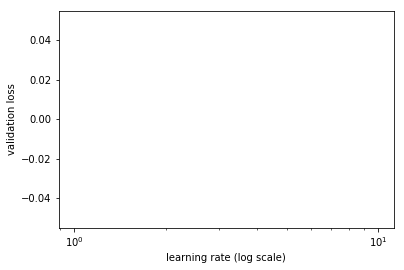

In [123]:
#anchors = anchors.cpu()
#grid_sizes = grid_sizes.cpu()
#anchor_cnr = anchor_cnr.cpu()


ssd_loss(batch, y, False)

learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100, lr/10, lr])

learn.lr_find(lrs/1000, 1.)
learn.sched.plot()

In [124]:
learn.fit(lr, n_cycle=1, cycle_len=CYCLE_LEN, use_clr=(20,10))

--calc_lr nb: 5, cut_div: 10, cut_pt: 0


  0%|          | 0/5 [00:00<?, ?it/s]>>ssd_loss()
--calc_lr nb: 5, cut_div: 10, cut_pt: 0
 20%|██        | 1/5 [00:01<00:07,  1.86s/it, loss=135]>>ssd_loss()
--calc_lr nb: 5, cut_div: 10, cut_pt: 0
 40%|████      | 2/5 [00:02<00:03,  1.02s/it, loss=123]>>ssd_loss()
--calc_lr nb: 5, cut_div: 10, cut_pt: 0
 60%|██████    | 3/5 [00:02<00:01,  1.35it/s, loss=122]>>ssd_loss()
--calc_lr nb: 5, cut_div: 10, cut_pt: 0
 80%|████████  | 4/5 [00:02<00:00,  1.67it/s, loss=123]>>ssd_loss()
--calc_lr nb: 5, cut_div: 10, cut_pt: 0
>>ssd_loss()
>>ssd_loss()
epoch      trn_loss   val_loss   
    0      108.878467 108.034987



[array([108.03499])]

In [125]:
learn.fit(lr, 1, cycle_len=CYCLE_LEN, use_clr=(20,10))

learn.save('0')

--calc_lr nb: 5, cut_div: 10, cut_pt: 0


  0%|          | 0/5 [00:00<?, ?it/s]>>ssd_loss()
--calc_lr nb: 5, cut_div: 10, cut_pt: 0
 20%|██        | 1/5 [00:01<00:07,  1.90s/it, loss=119]>>ssd_loss()
--calc_lr nb: 5, cut_div: 10, cut_pt: 0
 40%|████      | 2/5 [00:02<00:03,  1.05s/it, loss=94.7]>>ssd_loss()
--calc_lr nb: 5, cut_div: 10, cut_pt: 0
 60%|██████    | 3/5 [00:02<00:01,  1.31it/s, loss=109] >>ssd_loss()
--calc_lr nb: 5, cut_div: 10, cut_pt: 0
 80%|████████  | 4/5 [00:02<00:00,  1.62it/s, loss=123]>>ssd_loss()
--calc_lr nb: 5, cut_div: 10, cut_pt: 0
>>ssd_loss()
>>ssd_loss()
epoch      trn_loss   val_loss   
    0      108.962054 105.098756



In [126]:
learn.load('0')

In [127]:
# ## Testing

print('>>Testing')

x, y = next(iter(md.val_dl))
x, y = V(x), V(y)

learn.model.eval()

>>Testing


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [128]:
#run a batch of images through the learner (ie to_gpu(nn.Sequential(*(layers+fc_layers))))
batch = learn.model(x)
#deconstuct the result
b_clas, b_bb = batch

print(f'b_clas.size(): {b_clas.size()}')
print(f'b_bb.size(): {b_clas.size()}')

b_clas.size(): torch.Size([64, 16, 7])
b_bb.size(): torch.Size([64, 16, 7])


In [129]:
#print(f'b_clas: {b_clas}')
idx=1
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox, clas = get_y(y[0][idx], y[1][idx])
#print(f'bbox: {bbox}')
#print(f'clas: {clas}')

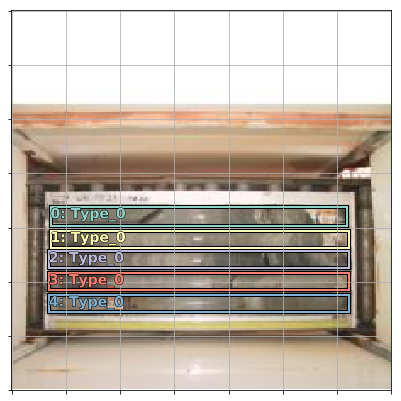

In [130]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    prs_val = to_np(prs) if prs is not None else None
    clas_np = to_np(clas)
    #print(f'bbox pre scaling: {bbox}')
    bbox_np = to_np((bbox*224).long())
    return show_ground_truth(ax, ima, bbox_np, clas_np, prs_val, thresh)

fig, ax = plt.subplots(figsize = (7,7))
torch_gt(ax,ima, bbox, clas)
plt.savefig(f'figs/g2c_multi_anchor_{SHORT_CYCLE_LEN}_{CYCLE_LEN}')
plt.show()

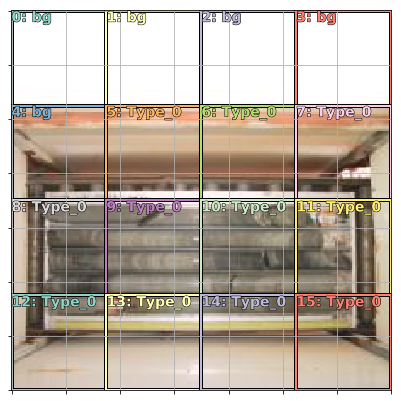

In [131]:
fig, ax = plt.subplots(figsize = (7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])
plt.savefig(f'figs/g2c_multi_anchor_max_{SHORT_CYCLE_LEN}_{CYCLE_LEN}')
plt.show()

In [132]:
print(f'grid_sizes: {grid_sizes}')
print(f'anchors: {anchors}')

a_ic = actn_to_bb(b_bboxi, anchors)

grid_sizes: Variable containing:
 0.2500
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

anchors: Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]



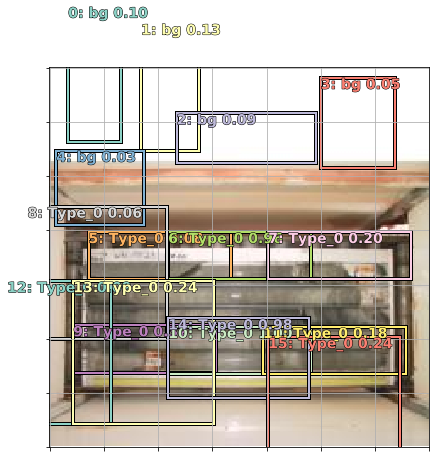

In [133]:
fig, ax = plt.subplots(figsize = (7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)
plt.savefig(f'figs/g2c_multi_jaccard_{SHORT_CYCLE_LEN}_{CYCLE_LEN}')
plt.show()

In [134]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
print(f'overlaps: {overlaps}')

print(f'overlaps.max(1): {overlaps.max(1)}')


print(f'overlaps.max(1): {overlaps.max(1)}')

overlaps: 

Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0773  0.1386
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0723  0.1292
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0745  0.1289
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0745  0.1289
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.1386  0.0698  0.0000  0.0000  0.0000  0.0000
 0.1292  0.0676  0.0000  0.0000  0.0000  0.0000
 0.1289  0.0675  0.0000  0.0000  0.0000  0.0000
 0.1289  0.0675  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0745  0.1289  0.1289  0.0674
[torch.cuda.FloatTensor of size 5x16 (GPU 0)]

overlaps.max(1): (
 0.1386
 0.1292
 0.1289
 0.1289
 0.1289
[torch.cuda.FloatTensor of size 5 (GPU 0)]
, 
 10
 10
 10
 10
 14
[torch.cuda.LongTensor of size 5 (GPU 0)]
)
overlaps.max(1): (
 0.1386
 0.1292
 0.1289
 0.1289
 0.1289
[torch.cuda.FloatTensor of size 5 (GPU

In [135]:
gt_overlap, gt_idx = map_to_ground_truth(overlaps)
gt_overlap, gt_idx

gt_clas = clas[gt_idx]; gt_clas


thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
print(f'pos_idx: {pos_idx}')

print(f'pos: {pos}')


pos_idx: 
 10
 14
[torch.cuda.LongTensor of size 2 (GPU 0)]

pos: 
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 1
 0
[torch.cuda.ByteTensor of size 16 (GPU 0)]



In [136]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o < len(id2cat) else 'bg' for o in gt_clas.data]

gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss = F.cross_entropy(b_clasi, gt_clas)
loc_loss, clas_loss

(Variable containing:
  0.1349
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  1.2255
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [137]:
fig, axes = plt.subplots(3, 4, figsize = (16, 12))
for idx, ax in enumerate(axes.flat):
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox, clas = get_y(y[0][idx], y[1][idx])
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox, clas = get_y(bbox, clas); bbox, clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()
plt.savefig(f'figs/g2c_multi_final_{SHORT_CYCLE_LEN}_{CYCLE_LEN}')
plt.close()


In [138]:
end_ssm=timer()
elapsed_ssm = end_ssm - start_ssm
print(f'Single Shot Multi with SHORT_CYCLE_LEN: {SHORT_CYCLE_LEN}, CYCLE_LEN: {CYCLE_LEN} took {elapsed_ssm}sec')


Single Shot Multi with SHORT_CYCLE_LEN: 1, CYCLE_LEN: 1 took 16.197239667999384sec


In [139]:







'''
# ### Multi class classification

start_mc=timer()


MC_CSV = PATH/'tmp/mc.csv'

#get image id 12 from this dict -returns bbox and category id
trn_anno[12]

cats[7]

#for each image we dont want to repeat same labels
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
#change from list to space sep string
mcs = [' '.join(str(p) for p in o) for o in mc]
#print(f'mc: {mc}\n')
#print(f'mcs: {mcs}')


# In[16]:


df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn', 'clas'])
df.to_csv(MC_CSV, index=False)
df.head(n=2)

f_model = resnet34
sz = 224
bs = 64

print(f'PATH: {PATH}, JPEGS: {JPEGS}, MC_CSV: {MC_CSV}')

tfms = tfms_from_model(f_model, sz, crop_type= CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, bs, tfms=tfms)

md.classes


# data: training data for model, models: model architectures to base learner
# 
# NB we need to use ConvLearner.pretrained rater than ConvLearner as f_model is not populated
# 
# where pretrained calls ConvnetBuilder to build a model with self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))


learn = ConvLearner.pretrained(f=f_model, data=md)
type(learn)

learn.opt_fn = optim.Adam

#loss depends on optimizer, ensure Adam is set above
learn.lr_find()
learn.sched.plot(0)


lr = 2e-2

learn.fit(lr, n_cycle=1, cycle_len=SHORT_CYCLE_LEN, use_clr=(32,5))

lrs = np.array([lr/100, lr/10, lr])


# In[27]:


learn.freeze_to(-2)


# In[28]:


learn.lr_find(lrs/1000)
learn.sched.plot(0)

learn.fit(lrs/10, n_cycle=1, cycle_len=SHORT_CYCLE_LEN, use_clr=(32,5))

learn.save('mclas')

learn.load('mclas')

preds = learn.predict()
preds

x,_ = next(iter(md.val_dl))
x = to_np(x)

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    #Return the indices of the elements that are non-zero.
    ya = np.nonzero(preds[i]>0.4)[0]
    print(f'ya: {ya}')
    b = ','.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()
plt.savefig(f'figs/g2c_multi_classes_{SHORT_CYCLE_LEN}_{CYCLE_LEN}')

end_mc=timer()
elapsed_mc = end_mc - start_mc
print(f'Multiclass with SHORT_CYCLE_LEN: {SHORT_CYCLE_LEN}, CYCLE_LEN: {CYCLE_LEN} took {elapsed_mc}sec')
'''

"\n# ### Multi class classification\n\nstart_mc=timer()\n\n\nMC_CSV = PATH/'tmp/mc.csv'\n\n#get image id 12 from this dict -returns bbox and category id\ntrn_anno[12]\n\ncats[7]\n\n#for each image we dont want to repeat same labels\nmc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]\n#change from list to space sep string\nmcs = [' '.join(str(p) for p in o) for o in mc]\n#print(f'mc: {mc}\n')\n#print(f'mcs: {mcs}')\n\n\n# In[16]:\n\n\ndf = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn', 'clas'])\ndf.to_csv(MC_CSV, index=False)\ndf.head(n=2)\n\nf_model = resnet34\nsz = 224\nbs = 64\n\nprint(f'PATH: {PATH}, JPEGS: {JPEGS}, MC_CSV: {MC_CSV}')\n\ntfms = tfms_from_model(f_model, sz, crop_type= CropType.NO)\nmd = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, bs, tfms=tfms)\n\nmd.classes\n\n\n# data: training data for model, models: model architectures to base learner\n# \n# NB we need to use ConvLearner.pretrained rater than ConvLearner as f_mod